In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader  
import glob  
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score  
import cv2 

In [16]:
# from zipfile import ZipFile
# import os

# zip_path = "archive (6).zip"          # uploaded zip file
# extract_path = "archive (7)-1"          # folder to extract into

# # create folder if it does not exist
# os.makedirs(extract_path, exist_ok=True)

# with ZipFile(zip_path, 'r') as zipobj:
#     zipobj.extractall(extract_path)

# print("Extraction completed successfully!")

Extraction completed successfully!


In [7]:
import shutil
import os

os.makedirs("Data/brain_tumor_dataset/yes", exist_ok=True)
os.makedirs("Data/brain_tumor_dataset/no", exist_ok=True)

for f in glob.glob("archive (7)-1/yes/*.jpg"):
    shutil.copy(f, "Data/brain_tumor_dataset/yes")

for f in glob.glob("archive (7)-1/no/*.jpg"):
    shutil.copy(f, "Data/brain_tumor_dataset/no")

print("Images moved successfully!")

Images moved successfully!


In [8]:
tumor = []

for f in glob.glob("archive (7)-1/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # correct color
    tumor.append(img)

print("Tumor images:", len(tumor))


Tumor images: 154


In [9]:
healthy = []

for f in glob.glob("archive (7)-1/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    healthy.append(img)

print("Healthy images:", len(healthy))


Healthy images: 91


In [10]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [11]:
healthy.shape

(91, 128, 128, 3)

In [12]:
tumor.shape

(154, 128, 128, 3)

In [13]:
np.random.choice(10, 5, replace=False)

array([3, 6, 5, 0, 2], dtype=int32)

# Visualizing Brain MRI Images

In [14]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
        

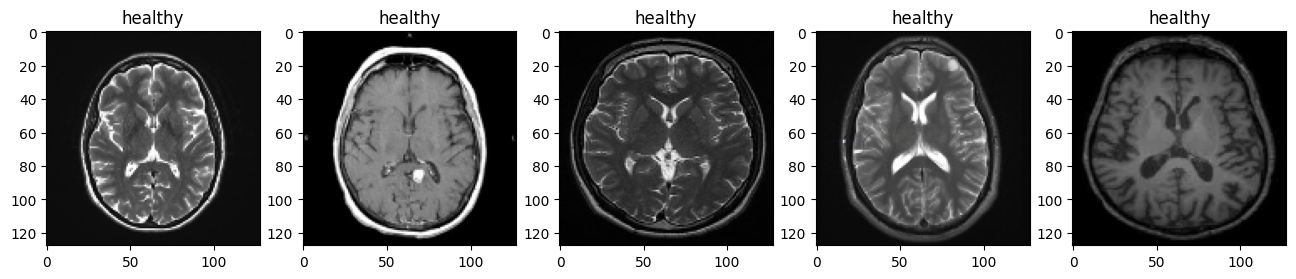

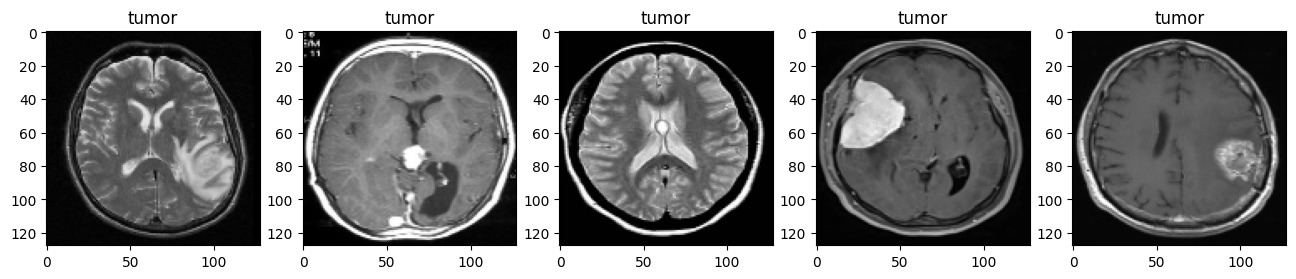

In [15]:
plot_random(healthy, tumor, num=5)

# Create Torch Dataset Class

In [16]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# Creating MRI cutom dataset class

In [17]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./Data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./Data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [18]:
mri_dataset = MRI()
mri_dataset.normalize()

# Creating a dataloader

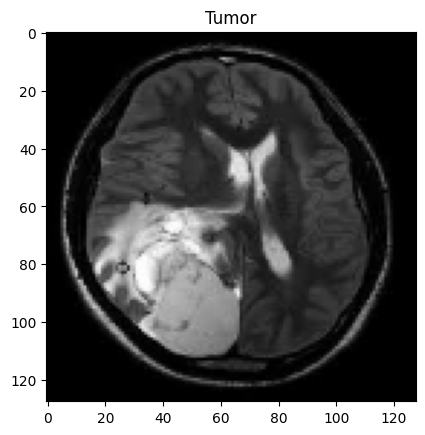

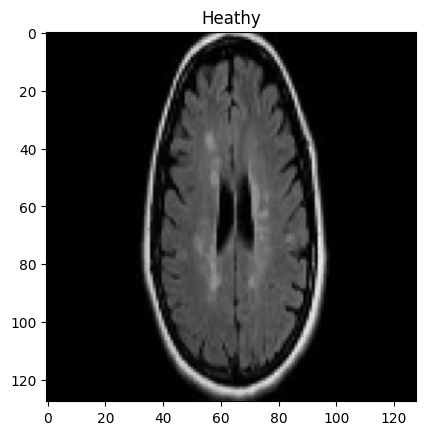

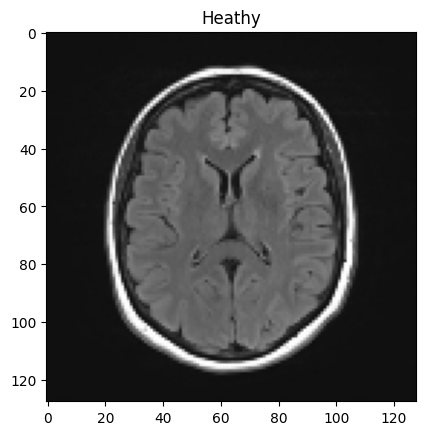

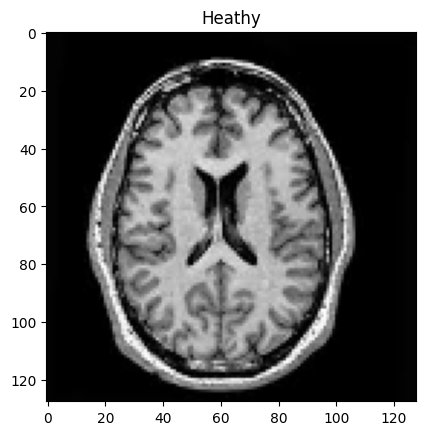

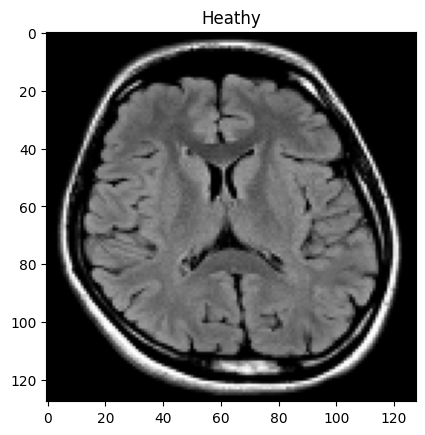

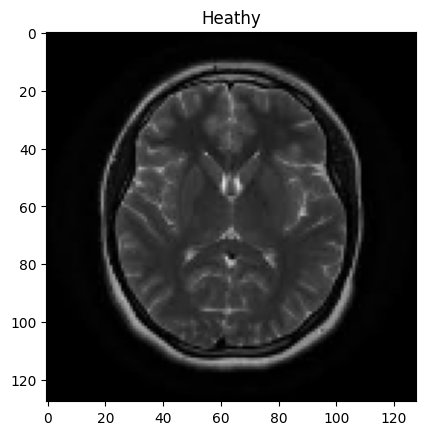

In [19]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break


# Create a model

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

In [21]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.3946, 0.7710, 0.5122, 0.7510, 0.0838, 0.3498, 0.4349, 0.8562, 0.2258,
        0.7155]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.3946, 0.7710, 0.5122, 0.7510, 0.0838, 0.3498, 0.4349, 0.8562, 0.2258,
        0.7155]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.1557, 0.5945, 0.2623, 0.5640, 0.0070, 0.1223, 0.1891, 0.7331, 0.0510,
        0.5119])


# Evaluate a New-Born Neural Network

In [22]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [23]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [24]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

In [25]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [26]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [27]:
accuracy_score(y_true, threshold(outputs))

0.6285714285714286

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

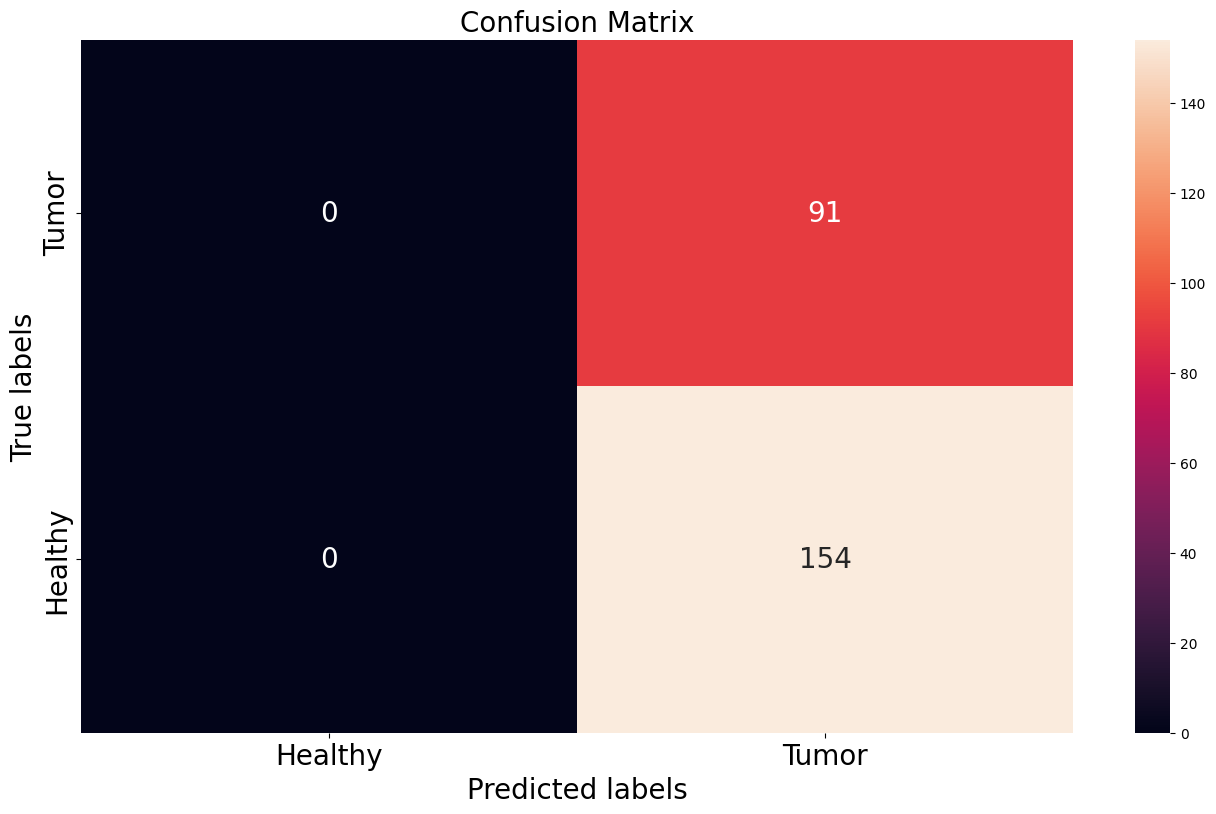

In [28]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

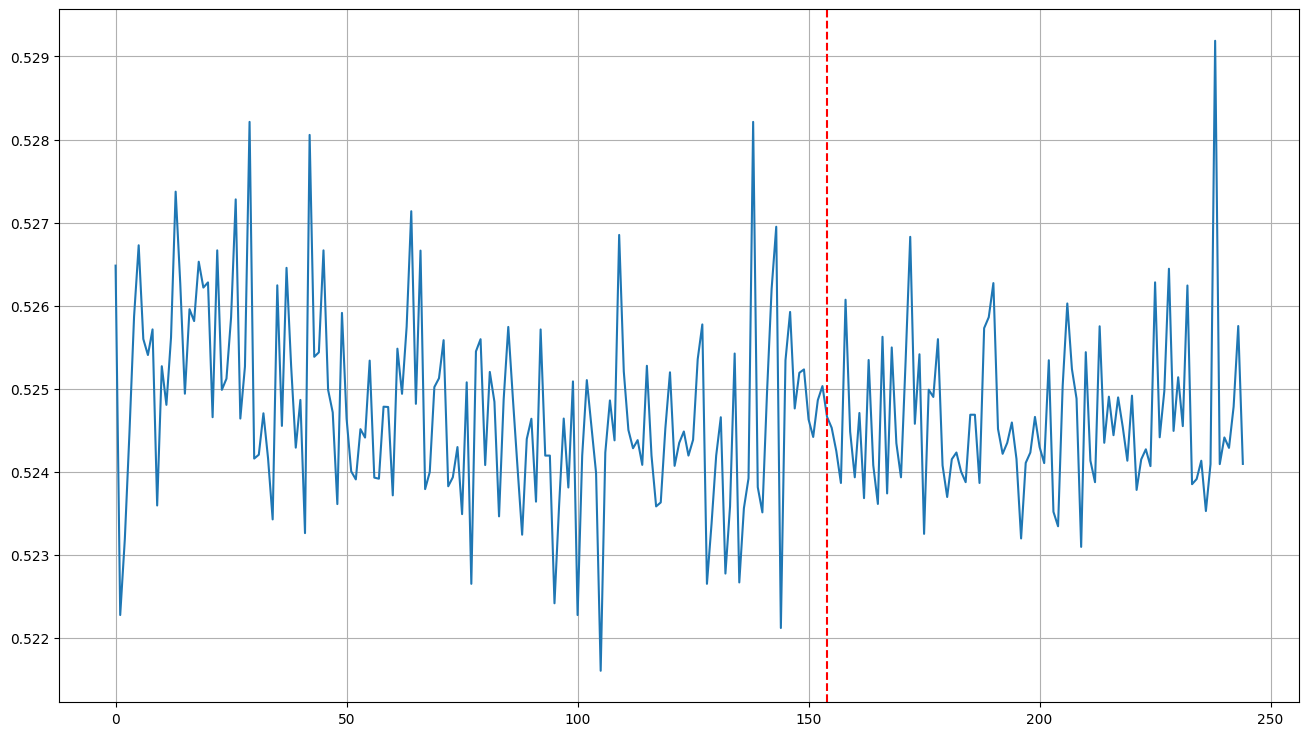

In [29]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Train the dumb model

In [30]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [31]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.628091
Train Epoch: 20	Loss: 0.595369
Train Epoch: 30	Loss: 0.556966
Train Epoch: 40	Loss: 0.534127
Train Epoch: 50	Loss: 0.520878
Train Epoch: 60	Loss: 0.500151
Train Epoch: 70	Loss: 0.481514
Train Epoch: 80	Loss: 0.476308
Train Epoch: 90	Loss: 0.456606
Train Epoch: 100	Loss: 0.442705
Train Epoch: 110	Loss: 0.434485
Train Epoch: 120	Loss: 0.411205
Train Epoch: 130	Loss: 0.416894
Train Epoch: 140	Loss: 0.385484
Train Epoch: 150	Loss: 0.377047
Train Epoch: 160	Loss: 0.364419
Train Epoch: 170	Loss: 0.347511
Train Epoch: 180	Loss: 0.341264
Train Epoch: 190	Loss: 0.324372
Train Epoch: 200	Loss: 0.299532
Train Epoch: 210	Loss: 0.278345
Train Epoch: 220	Loss: 0.268382
Train Epoch: 230	Loss: 0.242970
Train Epoch: 240	Loss: 0.225254
Train Epoch: 250	Loss: 0.210288
Train Epoch: 260	Loss: 0.180129
Train Epoch: 270	Loss: 0.168616
Train Epoch: 280	Loss: 0.147759
Train Epoch: 290	Loss: 0.133693
Train Epoch: 300	Loss: 0.140920
Train Epoch: 310	Loss: 0.101326
Train Epoch: 320	

# Evaluate a smart model

In [32]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [33]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

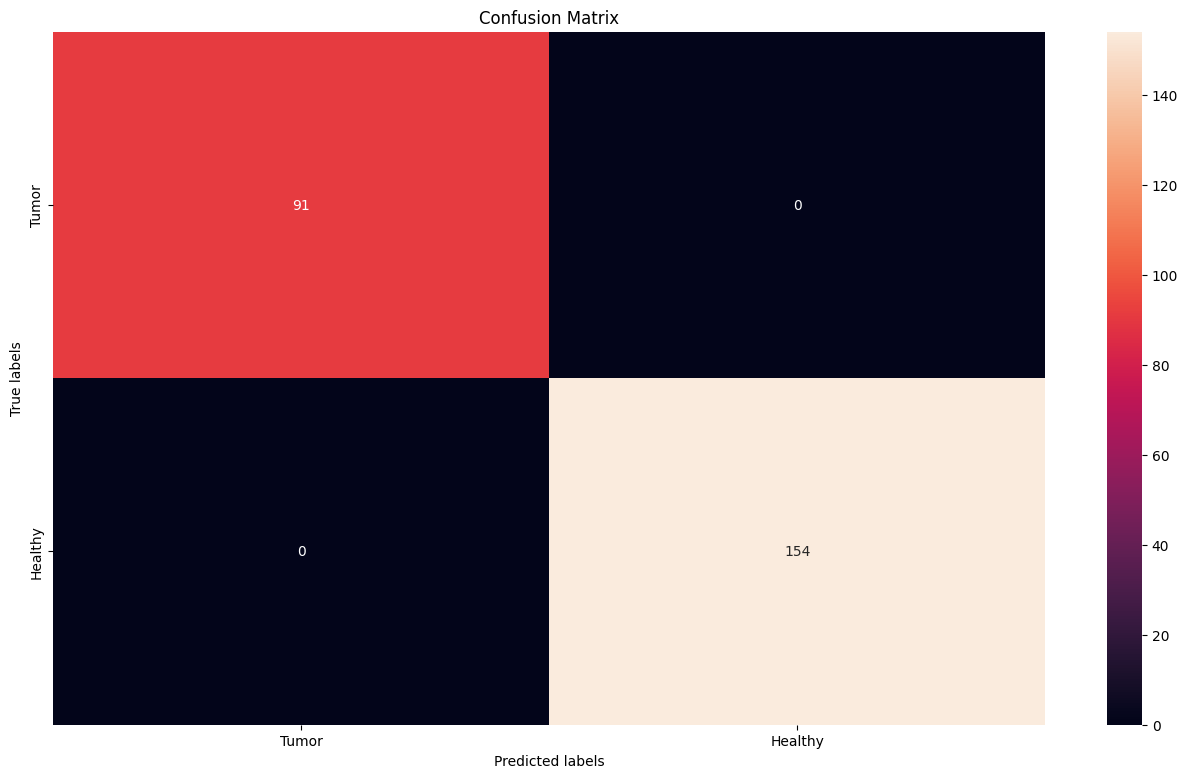

In [34]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])


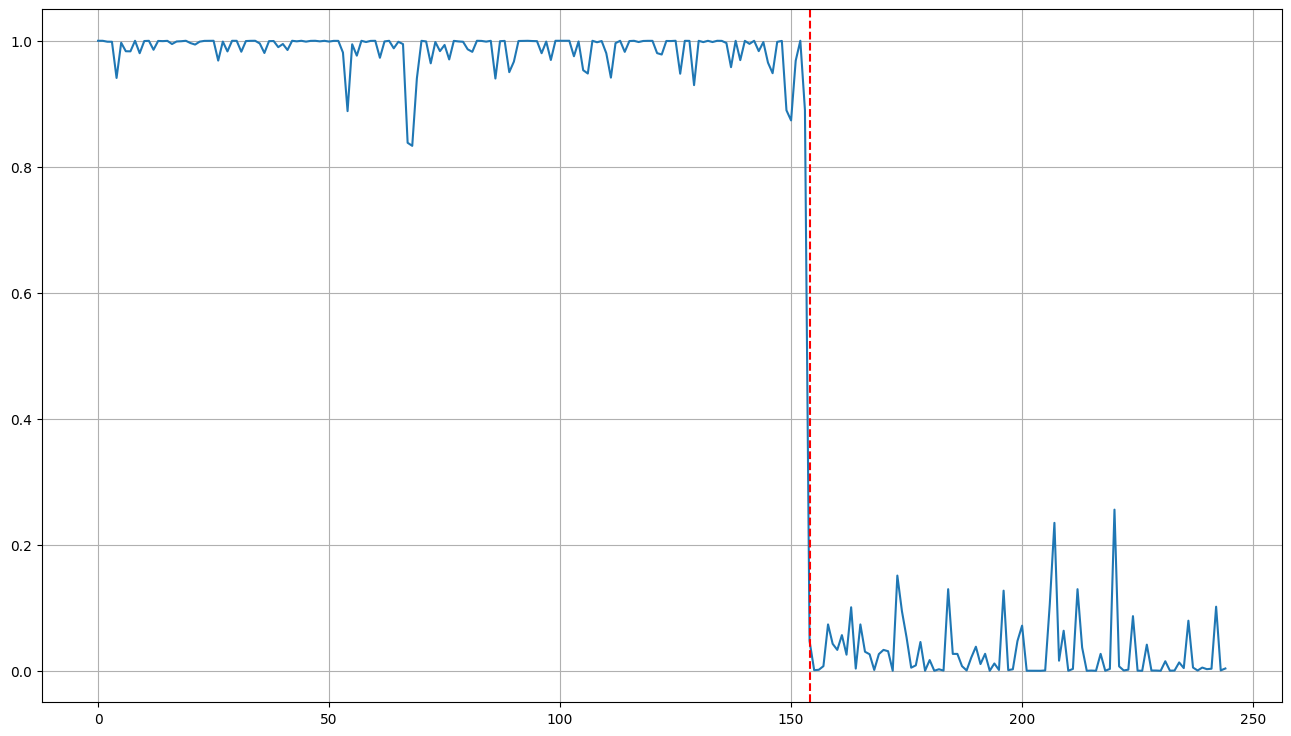

In [35]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [36]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [37]:
no_of_layers = 0
conv_layers = []

In [38]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [39]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [40]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

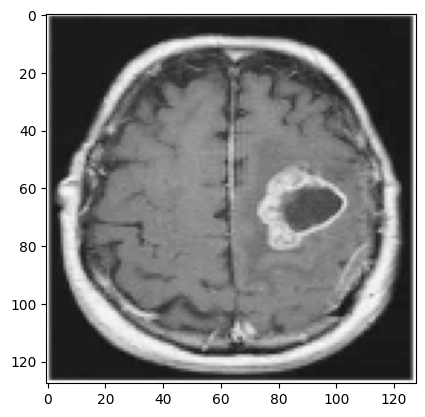

In [42]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))


In [43]:
img = torch.from_numpy(img).to(device)

In [44]:
img.shape

torch.Size([3, 128, 128])

In [45]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [46]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
  results.append(conv_layers[i](results[-1]))
outputs = results

# Training the Model

In [47]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [48]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./Data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./Data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [49]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [50]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [52]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [53]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [54]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [56]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.643423	Val Loss: 0.610666
Train Epoch: 20	Train Loss: 0.631113	Val Loss: 0.590155
Train Epoch: 30	Train Loss: 0.600152	Val Loss: 0.569180
Train Epoch: 40	Train Loss: 0.533145	Val Loss: 0.556029
Train Epoch: 50	Train Loss: 0.498148	Val Loss: 0.578847
Train Epoch: 60	Train Loss: 0.495266	Val Loss: 0.585275
Train Epoch: 70	Train Loss: 0.465718	Val Loss: 0.604866
Train Epoch: 80	Train Loss: 0.452715	Val Loss: 0.619240
Train Epoch: 90	Train Loss: 0.433523	Val Loss: 0.634175
Train Epoch: 100	Train Loss: 0.456620	Val Loss: 0.634623
Train Epoch: 110	Train Loss: 0.381871	Val Loss: 0.624713
Train Epoch: 120	Train Loss: 0.359185	Val Loss: 0.646426
Train Epoch: 130	Train Loss: 0.414081	Val Loss: 0.638791
Train Epoch: 140	Train Loss: 0.378278	Val Loss: 0.672554
Train Epoch: 150	Train Loss: 0.392511	Val Loss: 0.644160
Train Epoch: 160	Train Loss: 0.314494	Val Loss: 0.630472
Train Epoch: 170	Train Loss: 0.329687	Val Loss: 0.647518
Train Epoch: 180	Train Loss: 0.295135	Va

Text(0, 0.5, 'Loss')

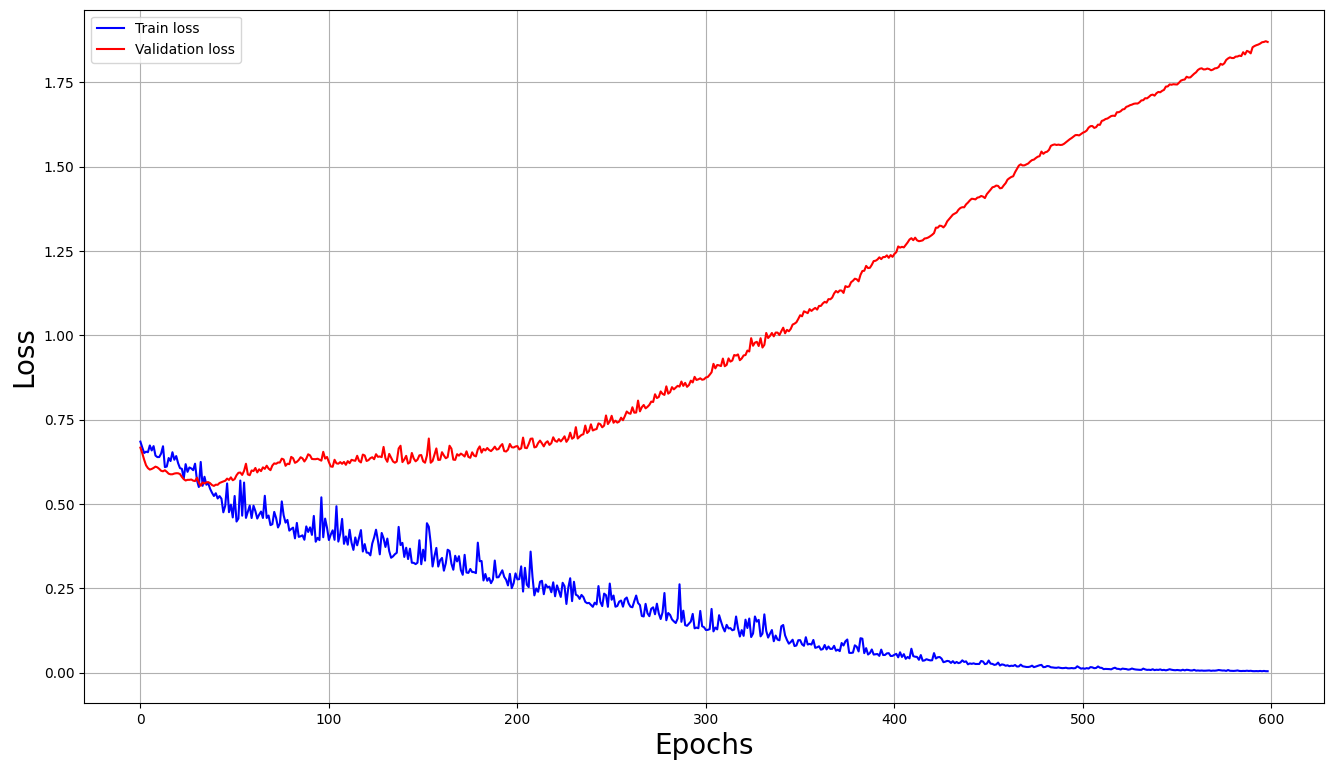

In [57]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

# Save Model for Web App Integration

In [58]:
# Save the model state_dict (weights and biases)
torch.save(model.state_dict(), './brain_tumor_model.pth')
print("Model saved as 'brain_tumor_model.pth'")

Model saved as 'brain_tumor_model.pth'


# Save Model for Web App Integration

In [59]:
# Example: How to load the model in your web app

# 1. Create a new model instance
loaded_model = CNN().to(device)

# 2. Load the saved weights
loaded_model.load_state_dict(torch.load('./brain_tumor_model.pth'))

# 3. Set to evaluation mode
loaded_model.eval()

print("Model loaded successfully!")
print("Now you can use loaded_model for inference in your web application")

Model loaded successfully!
Now you can use loaded_model for inference in your web application
